In [1]:
import numpy as np
import scipy.linalg as lalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
def heat_solver(x_domain, t_domain, D, n_x=10, n_t=10, u_0=(lambda x : 0)) :
    """Solves the heat equation du/dt = D * d^2u/dx^2 using the Crank-Nicholson method and Dirichlet boundary conditions u=0

    Args:
        x_domain (1*2 array_like) : boundaries of the interval to use for x
        t_domain (1*2 array_like) : boundaries of the interval to use for t, usually t_domain[0]==0
        D (float) : conductivity parameter of the heat equation
        n_x (int, optional) : grid size over x_domain
        n_t (int, optional) : grid size over t_domain
        u_0 (function, optional) : initial conditions function
        condition (string, optional) : type of boundary conditions, between "dirichlet", "newmann" and "robin". 
                                       We set a*u + b*du/dx = c. Dirichlet: b==0, Newmann: a==0, Robin: c==0
        a (float, optional) : parameter for the boundary conditions
        b (float, optional) : parameter for the boundary conditions
        c (float, optional) : parameter for the boundary conditions

    Returns:
        x (1D ndarray) : mesh defined by x_domain and n_x
        t (1D ndarray) : mesh defined by t_domain and n_t
        u (2D ndarray) : values taken by the solution over x and t

    """
    x = np.linspace(x_domain[0], x_domain[1], n_x, endpoint=True)
    dx = x[1] - x[0]
    t = np.linspace(t_domain[0], t_domain[1], n_t, endpoint=True)
    dt = t[1] - t[0]

    alpha = D * dt / (dx**2)

    # Initialization
    u = np.empty((n_x, n_t))
    # t = 0 :
    for i in range(n_x) :
        u[i, 0] = u_0(x[i])
    # Boundary conditions :
    u[0] = np.full(n_t, 0)
    u[n_x - 1] = np.full(n_t, 0)

    # Defining M_left and M_right in the Crank-Nicholson method, and the LU decomposition
    d1 = np.full(n_x - 2, 2 + 2 * alpha)
    d2 = np.full(n_x - 3, -alpha)
    d3 = np.full(n_x - 3, -alpha)
    M_l = np.diag(d1) + np.diag(d2, 1) + np.diag(d3, -1)

    d1 = np.full(n_x - 2, 2 - 2 * alpha)
    d2 = np.full(n_x - 3, alpha)
    d3 = np.full(n_x - 3, alpha)
    M_r = np.diag(d1) + np.diag(d2, 1) + np.diag(d3, -1)
    
    lu, piv = lalg.lu_factor(M_l)

    # Solving system
    for i in range(1, n_t) :
        q = M_r @ u[1:(n_x - 1), i - 1]
        u[1:(n_x - 1), i] = lalg.lu_solve((lu, piv), q)

    return x, t, u
 
    

In [3]:
u_0 = lambda x : np.sin(np.pi * x)
x, t, u = heat_solver(x_domain=[0, 1], t_domain=[0, 1], n_x=100, n_t=100, D = 0.3,  u_0 = u_0)

In [4]:
def plot_solution(x, t, u, cmap='viridis') :
    """Plots u as a function of x and t

    Args:
        x (1D ndarray) : x_axis values
        t (1D ndarray) : y_axis values
        u (2D ndarray) : z_axis values for x and t

    Returns:
        fig (Figure) : 3d plot of u = f(x, t)
    
    """
    x, t = np.meshgrid(x, t)

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(x, t, u.T, cmap=cmap)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("u")

    return fig

c:\Users\anass\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  app.launch_new_instance()


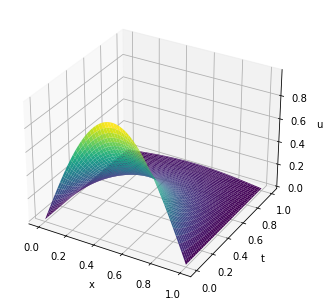

In [5]:
heat_plot = plot_solution(x, t, u)

In [6]:
def theta(h, theta_r, theta_s, n, m, alpha) :
    """Calculates volumetric soil moisture

    Args:
        h (float) : water pressure head
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter
    
    Returns:
        theta (float) : volumetric soil moisture
    """
    if h >= 0 :
        return theta_s

    return theta_r + (theta_s - theta_r) * ((1 + np.abs(alpha * h)**n)**(-m))

def S(theta, theta_r, theta_s) :
    """Calculates relative saturation

    Args:
        theta (float) : volumetric soil moisture
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture

    Returns:
        S (float) : relative saturation
    """
    return (theta - theta_r) / (theta_s - theta_r)

def h_(theta, theta_r, theta_s, n, m, alpha) :
    """Calculates water pressure head

    Args:
        theta (float) : volumetric soil moisture
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter
    
    Returns:
        h (float) : water pressure head
    """
    s = S(theta, theta_r, theta_s)
    return -((s**(-1 / m) - 1)**(1 / n)) / alpha

def k(h, S, k_s, m) :
    """Calculates hydraulic conductivity

    Args:
        h (float) : water pressure head
        S (float) : relative saturation
        k_s (float) : saturated hydraulic conductivity
        m (float) : van Genuchten model parameter
    
    Returns:
        K (float) : hydraulic conductivity
    """
    if h >= 0 :
        return k_s

    return k_s * np.sqrt(S) * ((1 - (1 - S**(1/m))**m)**2)

def C_(h, theta_r, theta_s, n, m, alpha) :
    """Calculates water capacity (dtheta/dh)

    Args:
        h (float) : water pressure head
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter

    Returns:
        C (float) : water capacity
    """
    if h >= 0 :
        return 10**(-20)
    
    return 10**(-20) + ((theta_s - theta_r) * m * n * alpha * (np.abs(alpha * h)**(n - 1))) / ((1 + np.abs(alpha * h)**n)**(m + 1))


In [7]:
# Setting constants

theta_r = 0.075
theta_s = 0.287
k_s = 1.5
alpha = 0.05
n = 2

param = [theta_r, theta_s, k_s, alpha, n]

h_t0 = -65
h_z0 = -65
h_z60 = -20.7

dz = 1
dt = 1

In [8]:
def richards_solver(z_max, t_max, dz=dz, dt=dt, h_t0=h_t0, h_z0=h_z0, h_z_max=h_z60, downbound="dirichlet", J_z0=0, topbound="dirichlet", timevar=(lambda x : 0), param=param) :
    """
    """

    theta_r, theta_s, k_s, alpha, n = param
    m = 1 - 1 / n

    Svec = np.vectorize(S)
    kvec = np.vectorize(k)
    thvec = np.vectorize(theta)
    hvec = np.vectorize(h_)
    Cvec = np.vectorize(C_)

    z = np.arange(0, z_max + dz, dz)
    n_z = len(z) - 2
    t = np.arange(0, t_max + dt, dt)
    n_t = len(t)

    # Initialization :
    h = np.empty((n_z + 2, n_t))
    # Initial condition t = 0 :
    h[:, 0] = np.full(n_z + 2, h_t0)
    thta = thvec(h[1:(n_z + 1), 0], theta_r, theta_s, n, m, alpha)
    # Boundary conditions :
    h[0] = np.full(n_t, h_z0)
    h[n_z + 1] = np.full(n_t, h_z_max) + np.vectorize(timevar)(t)
    
    for i in range(1, n_t) :
        
        s = Svec(thvec(h[:, i - 1], theta_r, theta_s, n, m, alpha), theta_r, theta_s)
        K = kvec(h[:, i - 1], s, k_s, m)
        
        K_05 = np.convolve(K, [1/2, 1/2], mode='valid')

        c = Cvec(h[:, i - 1], theta_r, theta_s, n, m, alpha)

        # Setting up main tridiagonal matrix coefficients

        A = -K_05[1:n_z] / (dz**2)
        B = c[1:(n_z + 1)] / dt + (K_05[1:] + K_05[:n_z]) / (dz**2)
        C = -K_05[1:n_z] / (dz**2)
        D = c[1:(n_z + 1)] * h[1:(n_z + 1), i - 1]/ dt - (K_05[1:] - K_05[:n_z]) / dz

        # Setting up down boundary coefficients     

        if downbound == "dirichlet" :
            B[0] = c[0] / dt + (K_05[1] + K_05[0]) / (dz**2)
            D[0] = c[0] * h[1, i - 1] / dt - (K_05[1] - K_05[0]) / dz + K_05[0] * h_z0 / (dz**2)

        else :
            B[0] = c[0] / dt + K_05[1] / (dz**2)
            D[0] = c[0] * h[1, i - 1] / dt + (J_z0 - K_05[1]) / dz

        # Setting up top boundary coefficients

        if topbound == "dirichlet" :
            B[n_z - 1] = c[n_z - 1] / dt + (K_05[n_z] + K_05[n_z - 1]) / (dz**2)
            D[n_z - 1] = c[n_z - 1] * h[n_z, i - 1] / dt + (K_05[n_z] - K_05[n_z - 1]) / dz - K_05[n_z] * h[n_z + 1, i - 1] / (dz**2)

        else : # Assuming unit flux density
            B[n_z - 1] = c[n_z - 1] / dt + K_05[n_z - 1] / (dz**2)
            D[n_z - 1] = c[n_z - 1] * h[n_z, i - 1] / dt + (K[n_z] - K_05[n_z - 1]) / dz

        # Solving system
        M = np.diag(A, -1) + np.diag(B) + np.diag(C, 1)
        lu, piv = lalg.lu_factor(M)
        hstar = lalg.lu_solve((lu, piv), D)

        if downbound == "dirichlet" :
            J_05 = -K_05[1] * ((hstar[0] - h[0, i - 1]) / dz - 1)
        else :
            J_05 = J_z0

        if topbound == "dirichlet" :
            J_nzplus05 = -K_05[n_z] * ((h[n_z + 1, i - 1] - hstar[n_z - 1]) / dz - 1)
        else : # Assuming unit flux density
            J_nzplus05 = K[n_z]

        j = -K_05[1:n_z] * (np.convolve(hstar, [1, -1], mode='valid') / dz - 1)
        J = np.concatenate(([J_05], j, [J_nzplus05]))

        thta = thta - (dt / dz) * np.convolve(J, [1, -1], mode='valid')
        h[1:n_z, i] = hvec(thta, theta_r, theta_s, n, m, alpha)
    
    return z, t, h
     

In [9]:
def richards_solver(z_max, t_max, dz=dz, dt=dt, h_t0=h_t0, h_z0=h_z0, h_z_max=h_z60, downbound="dirichlet", J_z0=0, topbound="dirichlet", timevar=(lambda x : 0), param=param) :
    """
    """

    theta_r, theta_s, k_s, alpha, n = param
    m = 1 - 1 / n

    Svec = np.vectorize(S)
    kvec = np.vectorize(k)
    thvec = np.vectorize(theta)
    hvec = np.vectorize(h_)
    Cvec = np.vectorize(C_)

    z = np.arange(0, z_max + dz, dz)
    n_z = len(z) - 2
    t = np.arange(0, t_max + dt, dt)
    n_t = len(t)

    # Initialization :
    h = np.empty((n_z + 2, n_t))
    # Initial condition t = 0 :
    h[:, 0] = np.full(n_z + 2, h_t0)
    thta = thvec(h[1:(n_z + 1), 0], theta_r, theta_s, n, m, alpha)
    # Boundary conditions :
    h[0] = np.full(n_t, h_z0)
    h[n_z + 1] = np.full(n_t, h_z_max) + np.vectorize(timevar)(t)
    
    for i in range(1, n_t) :
        
        s = Svec(thvec(h[:, i - 1], theta_r, theta_s, n, m, alpha), theta_r, theta_s)
        K = kvec(h[:, i - 1], s, k_s, m)
        
        K_05 = np.convolve(K, [1/2, 1/2], mode='valid')

        c = Cvec(h[:, i - 1], theta_r, theta_s, n, m, alpha)

        # Setting up main tridiagonal matrix coefficients

        A = -K_05[1:n_z] / (dz**2)
        B = c[1:(n_z + 1)] / dt + (K_05[1:] + K_05[:n_z]) / (dz**2)
        C = -K_05[1:n_z] / (dz**2)
        D = c[1:(n_z + 1)] * h[1:(n_z + 1), i - 1]/ dt - (K_05[1:] - K_05[:n_z]) / dz

        # Setting up down boundary coefficients     

        if downbound == "dirichlet" :
            B[0] = c[0] / dt + (K_05[1] + K_05[0]) / (dz**2)
            D[0] = c[0] * h[1, i - 1] / dt - (K_05[1] - K_05[0]) / dz + K_05[0] * h_z0 / (dz**2)

        else :
            B[0] = c[0] / dt + K_05[1] / (dz**2)
            D[0] = c[0] * h[1, i - 1] / dt + (J_z0 - K_05[1]) / dz

        # Setting up top boundary coefficients

        if topbound == "dirichlet" :
            B[n_z - 1] = c[n_z - 1] / dt + (K_05[n_z] + K_05[n_z - 1]) / (dz**2)
            D[n_z - 1] = c[n_z - 1] * h[n_z, i - 1] / dt + (K_05[n_z] - K_05[n_z - 1]) / dz - K_05[n_z] * h[n_z + 1, i - 1] / (dz**2)

        else : # Assuming unit flux density
            B[n_z - 1] = c[n_z - 1] / dt + K_05[n_z - 1] / (dz**2)
            D[n_z - 1] = c[n_z - 1] * h[n_z, i - 1] / dt + (K[n_z] - K_05[n_z - 1]) / dz

        # Solving system
        M = np.diag(A, -1) + np.diag(B) + np.diag(C, 1)
        lu, piv = lalg.lu_factor(M)
        hstar = lalg.lu_solve((lu, piv), D)

        if downbound == "dirichlet" :
            J_05 = -K_05[1] * ((hstar[0] - h[0, i - 1]) / dz - 1)
        else :
            J_05 = J_z0

        if topbound == "dirichlet" :
            J_nzplus05 = -K_05[n_z] * ((h[n_z + 1, i - 1] - hstar[n_z - 1]) / dz - 1)
        else : # Assuming unit flux density
            J_nzplus05 = K[n_z]

        j = -K_05[1:n_z] * (np.convolve(hstar, [1, -1], mode='valid') / dz - 1)
        J = np.concatenate(([J_05], j, [J_nzplus05]))

        thta = thta - (dt / dz) * np.convolve(J, [1, -1], mode='valid')
        h[1:n_z, i] = hvec(thta, theta_r, theta_s, n, m, alpha)
    
    return z, t, h
     

In [16]:
richards_solver(z_max=60, t_max=50)

TypeError: can't convert complex to float

In [17]:
def theta(h, theta_r, theta_s, n, m, alpha) :
    """Calculates volumetric soil moisture

    Args:
        h (float) : water pressure head
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter
    
    Returns:
        theta (float) : volumetric soil moisture
    """
    if h >= 0 :
        return theta_s

    return theta_r + (theta_s - theta_r) * ((1 + np.abs(alpha * h)**n)**(-m))

def S(theta, theta_r, theta_s) :
    """Calculates relative saturation

    Args:
        theta (float) : volumetric soil moisture
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture

    Returns:
        S (float) : relative saturation
    """
    return (theta - theta_r) / (theta_s - theta_r)

def h_(theta, theta_r, theta_s, n, m, alpha) :
    """Calculates water pressure head

    Args:
        theta (float) : volumetric soil moisture
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter
    
    Returns:
        h (float) : water pressure head
    """
    s = S(theta, theta_r, theta_s)
    return -((s**(-1 / m) - 1)**(1 / n)) / alpha

def k(h, S, k_s, m) :
    """Calculates hydraulic conductivity

    Args:
        h (float) : water pressure head
        S (float) : relative saturation
        k_s (float) : saturated hydraulic conductivity
        m (float) : van Genuchten model parameter
    
    Returns:
        K (float) : hydraulic conductivity
    """
    if h >= 0 :
        return k_s

    return k_s * np.sqrt(S) * ((1 - (1 - S**(1/m))**m)**2)

def C_(h, theta_r, theta_s, n, m, alpha) :
    """Calculates water capacity (dtheta/dh)

    Args:
        h (float) : water pressure head
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter

    Returns:
        C (float) : water capacity
    """
    if h >= 0 :
        return 10**(-20)
    
    return 10**(-20) + ((theta_s - theta_r) * m * n * alpha * (np.abs(alpha * h)**(n - 1))) / ((1 + np.abs(alpha * h)**n)**(m + 1))


In [18]:
# Setting constants

theta_r = 0.075
theta_s = 0.287
k_s = 1.5
alpha = 0.05
n = 2
m = 1 - 1 / n

param = [theta_r, theta_s, k_s, alpha, n, m]

h_t0 = -65
h_z0 = -65
h_z60 = -20.7

dz = 1
dt = 1

In [19]:
def picard_solver(z_max, t_max, dz=dz, dt=dt, h_t0=h_t0, downbound="dirichlet", h_z0=h_z0, J_z0=0, topbound="dirichlet", h_z_max=h_z60, timevar=(lambda x : 0), J_z_max=0, param=param, n_iter=10) :
    """
    """
    
    theta_r, theta_s, k_s, alpha, n, m = param

    Svec = np.vectorize(S)
    kvec = np.vectorize(k)
    thvec = np.vectorize(theta)
    Cvec = np.vectorize(C_)

    z = np.arange(0, z_max + dz, dz)
    n_z = len(z)
    t = np.arange(0, t_max + dt, dt)
    n_t = len(t)

    # Initialization :
    h = np.empty((n_z, n_t))
    # Initial condition t = 0 :
    h[:, 0] = np.full(n_z, h_t0)
    # Boundary conditions :
    if downbound == "dirichlet" :
        h[0] = np.full(n_t, h_z0)
    if topbound == "dirichlet" :
        h[n_z - 1] = np.full(n_t, h_z_max)

    for i in range(1, n_t) :
        h0 = h[:, i - 1]
        thta0 = thvec(h0, theta_r, theta_s, n, m, alpha)

        h[:, i] = np.copy(h0)
        h[n_z - 1, i] = h_z_max + timevar(t[i])

        for j in range(n_iter) :
            hm = h[:, i]
            thtam = thvec(hm, theta_r, theta_s, n, m, alpha)
            hdiff = np.convolve(hm, [1, -1], mode='valid')

            s = Svec(thtam, theta_r, theta_s)
            K = kvec(hm, s, k_s, m)

            K05 = np.convolve(K, [1/2, 1/2], mode='valid')
            Kplus05 = K05[1:]
            Kminus05 = K05[:(n_z - 2)]

            c = Cvec(hm, theta_r, theta_s, n, m, alpha)

            A = -Kminus05 / (dz**2)
            B = c[1:(n_z - 1)] / dt + (Kplus05 + Kminus05) / (dz**2)
            C = -Kplus05 / (dz**2)
            D = (Kplus05 * hdiff[1:] - Kminus05 * hdiff[:(n_z - 2)]) / (dz**2) - (Kplus05 - Kminus05) / dz - (thtam - thta0)[1:(n_z - 1)] / dt

            if downbound == "dirichlet" :
                B0 = 1
                C0 = 0
                D0 = 0
            
            elif downbound == "free_drainage" :
                B0 = c[0] / dt + 2 * K[0] / (dz**2)
                C0 = -2 * K[0] / (dz**2)
                D0 = 2 * K[0] * hdiff[0] / (dz**2) - (K05[0] - K[0]) / dz - (thtam - thta0)[0] / dt
            
            elif downbound == "flux" :
                B0 = c[0] / dt + 2 * K[0] / (dz**2)
                C0 = -2 * K[0] / (dz**2)
                D0 = 2 * K[0] * hdiff[0] / (dz**2) - (J_z0 / K[0]) * (K05[0] - J_z0) / dz - 2 * (K[0] - J_z0) / dz - (thtam - thta0)[0] / dt

            if topbound == "dirichlet" :
                Anz = 0
                Bnz = 1
                Dnz = 0
            
            elif topbound == "free_drainage" :
                Anz = -2 * K[n_z - 1] / (dz**2)
                Bnz = c[n_z - 1] / dt + 2 * K[n_z - 1] / (dz**2)
                Dnz = -2 * K[n_z - 1] * hdiff[n_z - 2] / (dz**2) - (K[n_z - 1] - K05[n_z - 2]) / dz - (thtam - thta0)[n_z - 1] / dt
            
            elif topbound == "flux" :
                Anz = -2 * K[n_z - 1] / (dz**2)
                Bnz = c[n_z - 1] / dt + 2 * K[n_z - 1] / (dz**2)
                Dnz = -2 * K[n_z - 1] * hdiff[n_z - 2] / (dz**2) - (J_z_max / K[n_z - 1]) * (J_z_max - K05[n_z - 2]) / dz + 2 * (K[n_z - 1] - J_z_max) / dz - (thtam - thta0)[n_z - 1] / dt

            A = np.concatenate((A, [Anz]))
            B = np.concatenate(([B0], B, [Bnz]))
            C = np.concatenate(([C0], C))
            D = np.concatenate(([D0], D, [Dnz]))

            M = np.diag(A, -1) + np.diag(B) + np.diag(C, 1)
            lu, piv = lalg.lu_factor(M)
            delta = lalg.lu_solve((lu, piv), D)
            
            h[:, i] += delta

    return z, t, h
    

In [20]:
z, t, h = picard_solver(z_max=60, t_max=50)

c:\Users\anass\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  app.launch_new_instance()


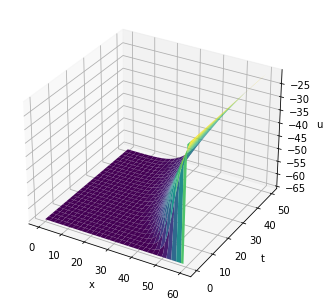

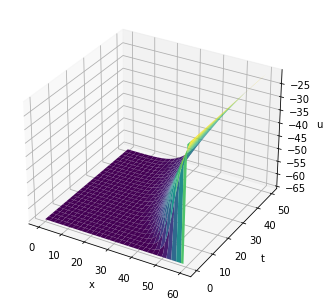

In [21]:
plot_solution(z, t, h)